In [1]:
#Ella Marin
#1/19/24
#Defining a YLGR Reference Frame

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import gala.coordinates as gc
from astroquery.gaia import Gaia
from astropy.table import Table
import pandas as pd
from scipy.optimize import minimize

from episode_functions import *

Can create a stream-aligned coordinate frame by specifying an exact origin for the new great circle coordinate frame (e.g., set to the progenitor system) along with the endpoints of the stream (which are often close to defining a great circle). In these cases, the great circle defined by the endpoints and the great circle defined by the origin may not be orthogonal. 

Question: If I don't know where the progenitor of YLGR is, should I estimate, or use the two endpoint method? 

Attempt #2) Using two endpoints, where one of the endpoints also serves as the origin

In [3]:
#Example code from Gala

# endpoints = coord.SkyCoord(
#     ra=[-38.8, 4.7]*u.deg,
#     dec=[-45.1, -51.7]*u.deg
# )
# origin = coord.SkyCoord(330., -48., unit=u.deg)
# frame4 = gc.GreatCircleICRSFrame.from_endpoints(  
#     endpoints[0], endpoints[1], origin=origin
# )
# frame4
# <GreatCircleICRSFrame Frame (pole=<ICRS Coordinate: (ra, dec) in deg
#     (359.13616655, 38.18404071)>, origin=<ICRS Coordinate: (ra, dec) in deg
#     (330., -48.)>, priority=origin)>

YLGR info:

30 degrees long

Endpoint 1: (-60, 20) or (300, 20) galactic

Endpoint 2: (-100, 50) or (260, 50) galactic

In [4]:
l = [-64, -94, -79] * u.degree
b = [22, 46, 34] * u.degree

coord_gal_min = SkyCoord(l = l[0], b = b[0], frame = 'galactic')
coord_gal_max = SkyCoord(l = l[1], b = b[1], frame = 'galactic')
coord_gal_origin = SkyCoord(l = l[2], b = b[2], frame = 'galactic')

coord_icrs_min = coord_gal_min.transform_to('icrs')
coord_icrs_max = coord_gal_max.transform_to('icrs')
coord_icrs_origin = coord_gal_origin.transform_to('icrs')

print(coord_icrs_min)
print(coord_icrs_max)
print(coord_icrs_origin)

<SkyCoord (ICRS): (ra, dec) in deg
    (184.40767941, -40.41627143)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.81750864, -9.5658455)>
<SkyCoord (ICRS): (ra, dec) in deg
    (172.80716891, -25.43281009)>


(320.0, 240.0)

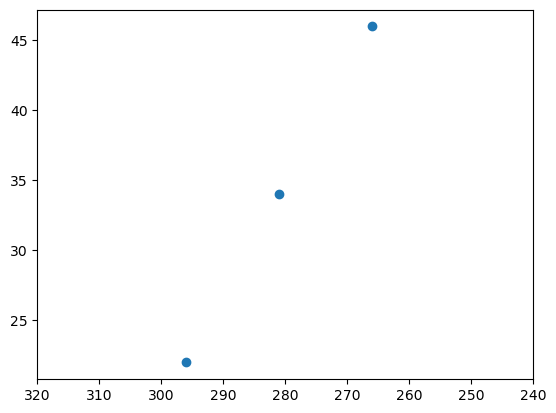

In [5]:
#Plot galactic coords to make sure they are on the same line. Confirmed

l_values = [coord_gal_min.l.value, coord_gal_max.l.value, coord_gal_origin.l.value]
b_values = [coord_gal_min.b.value, coord_gal_max.b.value, coord_gal_origin.b.value]

# Plot the SkyCoords
plt.scatter(l_values, b_values, marker='o', label='SkyCoords')
plt.xlim(320, 240)

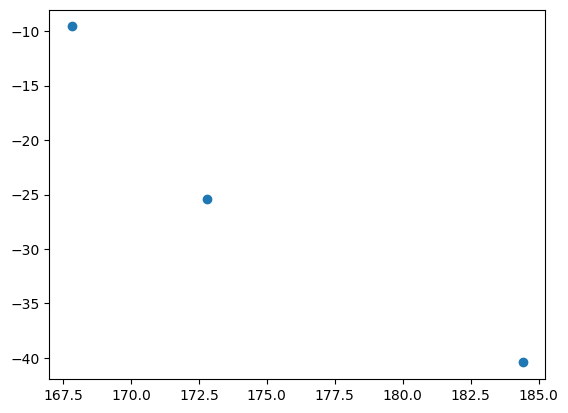

In [6]:
#Plot transformed ICRS coords
ra_values = [coord_icrs_min.ra.value, coord_icrs_max.ra.value, coord_icrs_origin.ra.value]
dec_values = [coord_icrs_min.dec.value, coord_icrs_max.dec.value, coord_icrs_origin.dec.value]

# Plot the SkyCoords
plt.scatter(ra_values, dec_values, marker='o', label='SkyCoords')

In [7]:
#Endpoints defined visually from graphs
#Going to extend endpoints past where I think the stream actually is

endpoints = SkyCoord(ra=[coord_icrs_min.ra.value, coord_icrs_max.ra.value]*u.degree, 
                     dec=[coord_icrs_min.dec.value,coord_icrs_max.dec.value]*u.degree, 
                          frame = 'icrs')

In [8]:
##NOT USING AN ORIGIN IN THIS EXAMPLE

#Origin should be set to the progenitor system, according to Gala
#which I am approximating to be in the center of the stream

#origin = SkyCoord(ra=coord_icrs_origin.ra.value, dec=coord_icrs_origin.dec.value, 
                  #frame = 'icrs', unit = u.degree)

In [9]:
ylgr_frame = gc.GreatCircleICRSFrame.from_endpoints(  
    endpoints[0], endpoints[1])

#not orthogonal, automatically adjusted, may impact things

In [10]:
ylgr_frame #put the frame in RA and DEC coords

#This produces a pole = the pole of a great circle is the point on the celestial sphere
#where the axis of rotation of the great circle intersects the sphere.

#And produces the origin, both in RA DEC coords

<GreatCircleICRSFrame Frame (pole=<ICRS Coordinate: (ra, dec) in deg
    (73.82867389, -22.42946132)>, origin=<ICRS Coordinate: (ra, dec) in deg
    (175.03836473, -25.21869543)>, priority=origin)>

In [11]:
coord_ylgr_min = coord_gal_min.transform_to(ylgr_frame)
coord_ylgr_max = coord_gal_max.transform_to(ylgr_frame)
coord_ylgr_origin = coord_gal_origin.transform_to(ylgr_frame)


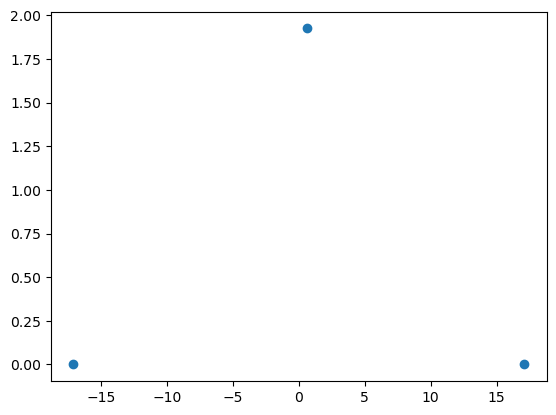

In [12]:
phi1_values = [coord_ylgr_min.phi1.value, coord_ylgr_max.phi1.value, coord_ylgr_origin.phi1.value]
phi2_values = [coord_ylgr_min.phi2.value, coord_ylgr_max.phi2.value, coord_ylgr_origin.phi2.value]

# Plot the SkyCoords
plt.scatter(phi1_values, phi2_values, marker='o', label='SkyCoords')

SO odd, when I do plot an origin point, it puts the two endpoints in the right place, but the origin is in the wrong place. But, if I don't plot an origin, then the endpoints are not in the right place, so I guess I will keep plotting origin? But how will that affect stuff later down. 

Now, going to attempt to transfrom my endpoints into this frame. 

In [13]:
filename = 'ylgr_starcoords.hdf'
ylgrstars_df = pd.read_hdf(filename,'ylgrstars_df')
ylgrstars_df

,l,b
0,-66.262393,24.535099
1,-66.891605,24.320836
2,-67.138796,26.304574
3,-67.934299,26.038791
4,-67.835423,24.051202
...,...,...
102,-90.888335,44.521390
103,-91.309522,44.724441
104,-91.872817,44.601180
105,-92.105026,44.302656


In [14]:
ylgr_gal = SkyCoord(l = ylgrstars_df.l, b = ylgrstars_df.b, frame = 'galactic', unit = u.degree)

ylgr_ylgr = ylgr_gal.transform_to(ylgr_frame)

ylgr_coords = [(coord.phi1.degree, coord.phi2.degree) for coord in ylgr_ylgr]

In [15]:
def find_optimal_x_axis(points):
    # Step 1: Compute the median of the y-coordinates
    median_y = np.median([point[1] for point in points])  # Assuming points are tuples (x, y)

    # Step 2: Place the x-axis at the level of the median
    x_axis_position = median_y

    # Step 3: Calculate the maximum absolute distance
    max_abs_distance = max(abs(point[1] - x_axis_position) for point in points)

    return x_axis_position, max_abs_distance

x_axis_position, max_abs_distance = find_optimal_x_axis(ylgr_coords)
print("Optimal x-axis position:", x_axis_position)
print("Maximum absolute distance:", max_abs_distance)


Optimal x-axis position: -0.060240964674220195
Maximum absolute distance: 2.044299916514073


In [16]:
print(x_axis_position + max_abs_distance + 4.50)
print(x_axis_position - max_abs_distance -4.50)

6.484058951839853
-6.604540881188294


In [17]:
def find_optimal_y_axis(points):
    # Step 1: Compute the median of the x-coordinates
    median_x = np.median([point[0] for point in points])  # Assuming points are tuples (x, y)

    # Step 2: Place the y-axis at the level of the median
    y_axis_position = median_x

    # Step 3: Calculate the maximum absolute distance
    max_abs_distance = max(abs(point[0] - y_axis_position) for point in points)

    # Repeat steps 2-3 if needed
    # If the points are symmetric around the y-axis, you might have multiple optimal positions.

    return y_axis_position, max_abs_distance


y_axis_position, max_abs_distance = find_optimal_y_axis(ylgr_coords)
print("Optimal y-axis position:", y_axis_position)
print("Maximum absolute distance:", max_abs_distance)

Optimal y-axis position: 3.8763462289201307
Maximum absolute distance: 17.689682884402494


In [18]:
print(y_axis_position + max_abs_distance + 2.00)
print(y_axis_position - max_abs_distance -2.00)

23.566029113322625
-15.813336655482363


Defining a rectangular region in the YLGR frame to select stars

In [19]:
phi1_min = -15.813336655482363 * u.degree #-20
phi1_max = 23.566029113322625 * u.degree #20
phi2_min = -6.604540881188294 * u.degree #-5
phi2_max = 6.484058951839853 * u.degree #5

In [20]:
def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

In [21]:
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

In [22]:
corners = SkyCoord(phi1=phi1_rect, phi2=phi2_rect, frame=ylgr_frame, unit = u.deg)
corners #this will print a fifth vertex, which closes the rectangle

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec) in deg
    (73.82867389, -22.42946132)>, origin=<ICRS Coordinate: (ra, dec) in deg
    (175.03836473, -25.21869543)>, priority=origin): (phi1, phi2) in deg
    [(-15.81333666, -6.60454088), (-15.81333666,  6.48405895),
     ( 23.56602911,  6.48405895), ( 23.56602911, -6.60454088),
     (-15.81333666, -6.60454088)]>

Use these to define rectangle!

Text(0, 0.5, 'phi2 (degree YLGR)')

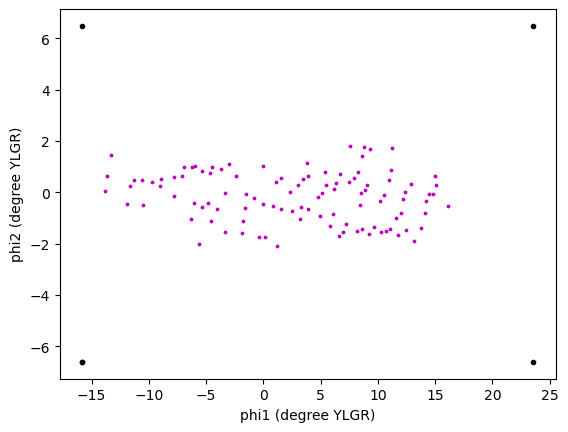

In [23]:
#Confirming the it is indeed a rectangular shape in YLGR frame

x = corners.phi1
y = corners.phi2

plt.plot(x, y, 'ko', markersize=3, alpha=1)

x_star = ylgr_ylgr.phi1.value
y_star = ylgr_ylgr.phi2.value

plt.scatter(x_star, y_star, c = 'm', s = 3)

plt.xlabel('phi1 (degree YLGR)')
plt.ylabel('phi2 (degree YLGR)')



In [24]:
ylgr_ylgr.phi1.value.min()

-13.813336655482363

In [25]:
corners_gal = corners.transform_to('galactic')
corners_gal

<SkyCoord (Galactic): (l, b) in deg
    [(300.93918691, 27.00691823), (289.78367281, 18.87685403),
     (253.54301506, 43.58416372), (263.2507842 , 55.07418324),
     (300.93918691, 27.00691823)]>

(310.0, 240.0)

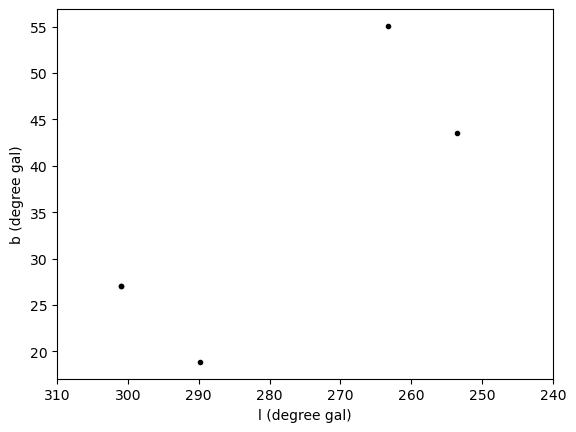

In [26]:
#Looking at shape in ICRS frame

x = corners_gal.l
y = corners_gal.b

plt.plot(x, y, 'ko', markersize=3, alpha=1)

plt.xlabel('l (degree gal)')
plt.ylabel('b (degree gal)')

plt.xlim(310, 240)

In [27]:
corners_icrs = corners.transform_to('icrs') #transforming corners from YLGR frame to ICRS frame
corners_icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(190.66951477, -35.83093328), (175.95186914, -42.26169143),
     (159.28855945,  -6.04259797), (171.41370419,  -1.04755663),
     (190.66951477, -35.83093328)]>

Text(0, 0.5, 'dec (degree ICRS)')

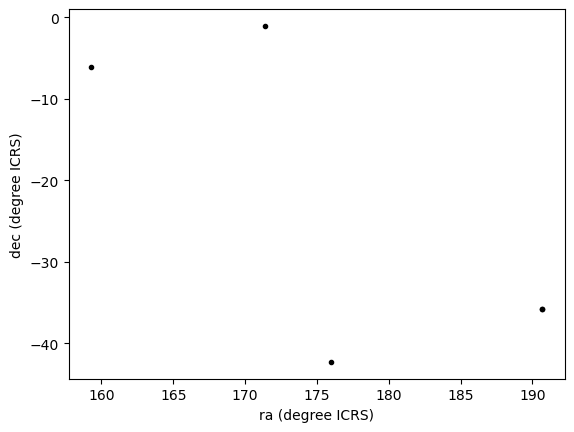

In [28]:
#Looking at shape in ICRS frame

x = corners_icrs.ra
y = corners_icrs.dec

plt.plot(x, y, 'ko', markersize=3, alpha=1)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')



In [29]:
def skycoord_to_string(skycoord):
    """Convert a one-dimenstional list of SkyCoord to string for Gaia's query format."""
    corners_list_str = skycoord.to_string()
    corners_single_str = ' '.join(corners_list_str)
    return corners_single_str.replace(' ', ', ')

In [30]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'190.67, -35.8309, 175.952, -42.2617, 159.289, -6.0426, 171.414, -1.04756, 190.67, -35.8309'

In [31]:
# Taken fom 'YLGR Play', these are final bounds I have selected. 
#specifying my numbers further based on Figure 11

# query_base = """SELECT
# TOP 10000
# {columns}
# FROM gaiadr3.gaia_source
# WHERE l BETWEEN 265 AND 295 
# AND b BETWEEN 20 AND 47
# AND pmra BETWEEN -3 AND 3
# AND pmdec BETWEEN -9 AND -3
# AND parallax BETWEEN -1 AND 1
# AND bp_rp BETWEEN 1.5 and 2
# AND 1 = CONTAINS (POINT(l, b), POLYGON({sky_point_list}))
# """




Now, try to query based on this new rectangular reference frame

In [32]:
columns = 'source_id, l, b, pmra, pmdec, parallax, ra, dec, bp_rp, \
phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_mag, \
phot_bp_mean_flux_error, phot_rp_mean_flux_error, phot_g_mean_flux_error,\
phot_bp_mean_flux, phot_rp_mean_flux, phot_g_mean_flux'

In [33]:
query_base = """SELECT
{columns}
FROM gaiadr3.gaia_source
WHERE (parallax - 2*parallax_error)<0.2
AND ruwe < 1.4
AND visibility_periods_used > 5
AND 1 = CONTAINS(POINT(ra, dec), POLYGON({sky_point_list}))
"""
#AND bp_rp BETWEEN 1.5 and 2.1
#AND phot_bp_mean_mag < 20.
#using a query with few modifiers -- later will pare down

In [34]:
query_base = query_base.format(columns=columns, sky_point_list = sky_point_list)
print(query_base)

SELECT
source_id, l, b, pmra, pmdec, parallax, ra, dec, bp_rp, phot_bp_mean_mag, phot_rp_mean_mag, phot_g_mean_mag, phot_bp_mean_flux_error, phot_rp_mean_flux_error, phot_g_mean_flux_error,phot_bp_mean_flux, phot_rp_mean_flux, phot_g_mean_flux
FROM gaiadr3.gaia_source
WHERE (parallax - 2*parallax_error)<0.2
AND ruwe < 1.4
AND visibility_periods_used > 5
AND 1 = CONTAINS(POINT(ra, dec), POLYGON(190.67, -35.8309, 175.952, -42.2617, 159.289, -6.0426, 171.414, -1.04756, 190.67, -35.8309))



In [35]:
job_rect = Gaia.launch_job_async(query_base)
print(job_rect)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=2341125>
          name           dtype      unit                                description                             n_bad
----------------------- ------- ------------ ------------------------------------------------------------------ -----
              source_id   int64              Unique source identifier (unique within a particular Data Release)     0
                      l float64          deg                                                 Galactic longitude     0
                      b float64          deg                                                  Galactic latitude     0
                   pmra float64     mas / yr                         Proper motion in right ascension direction     0
                  pmdec float64     mas / yr                             Proper motion in declination direction     0
               parallax float64          mas                                                         

In [36]:
results = job_rect.get_results()
results

#448556 points 1/23/24

source_id,l,b,pmra,pmdec,parallax,ra,dec,bp_rp,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_mag,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_error,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux
,deg,deg,mas / yr,mas / yr,mas,deg,deg,mag,mag,mag,mag,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s
int64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
3471538300609820672,296.221668509994,32.65963704137508,8.020113628297718,-3.1587755865565716,2.1884586305561577,186.3454488056503,-29.872390927443902,--,--,--,20.750885,--,--,0.9393813,--,--,94.31757626405177
3790783455945012864,262.24923039849995,53.33071305344118,-0.5035619122672832,-3.717323603017623,0.19549772448486513,169.93207677504503,-2.1380795281189715,0.7726002,20.285221,19.51262,20.08366,8.918765,7.6233087,0.92932487,105.0336756014774,124.19660409663933,174.3744520819258
3790407835284866688,263.7434153190325,53.16565113541854,-21.23373909681952,-4.674599819676521,-1.4626544848073966,170.57172401382505,-2.78471755160047,2.1206818,21.440489,19.319807,20.428148,7.6473074,9.233164,0.93908525,36.24275161896994,148.3321472783203,126.96594184468734
3790407942659746304,263.76387635125786,53.181848584545335,-7.006988666741497,-15.804448128842361,0.3364156023965263,170.5910008929613,-2.778233446312888,0.7530403,18.641747,17.888706,18.335926,8.40471,6.5298715,1.6519787,477.2192362070405,554.211411402118,872.1196591502065
3790407942659748480,263.7491281585512,53.17070757513304,-1.4069454402082386,-3.0947749457438545,1.2947992593027595,170.57740780726314,-2.7824666406084044,0.8404064,20.345387,19.50498,20.180965,8.182745,8.470958,0.99577934,99.37153635421666,125.07382608207466,159.4265236794126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151649222468998272,296.0775565795959,24.874697637076093,-9.833852712640995,3.783004074646538,-0.928058131749505,185.00712463913408,-37.5786612768041,1.2411461,20.738907,19.49776,20.203262,5.1207566,5.1277494,0.6200089,69.15988531994857,125.90817640686163,156.1858542776543
6151649222471132288,296.08827509903193,24.872854719981827,-7.774806613193921,0.050869331002661944,-1.3777438938033975,185.0189729978024,-37.58178988995955,1.1657429,20.516014,19.350271,20.15295,6.0540323,6.5653625,0.55571854,84.92028272640835,144.2280646199351,163.59361868964186


Text(0, 0.5, 'dec (degree ICRS)')

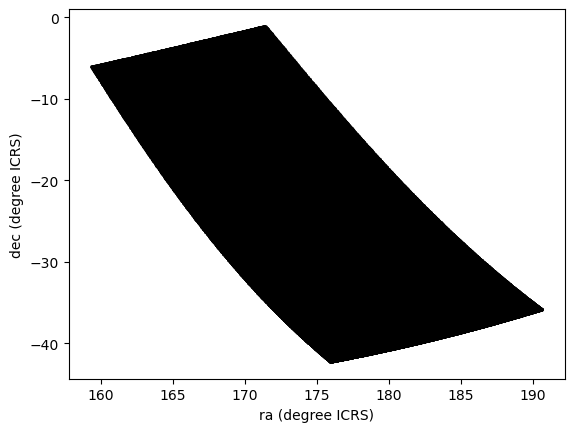

In [37]:
x = results['ra']
y = results['dec']
plt.plot(x, y, 'ko', markersize=0.5, alpha=1)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

In [38]:
# #Saving this file

filename = 'ylgr_rect_results.fits'
results.write(filename, overwrite=True)

In [39]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

259.0081787109375

In [40]:
filename = 'ylgr_rect_results.fits'
rectangle_results = Table.read(filename)

In [41]:
rectangle_results.info()

#2,066,263 total data points

<Table length=2341125>
          name           dtype    unit                              description                                class     n_bad
----------------------- ------- -------- ------------------------------------------------------------------ ------------ -----
              source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn     0
                      l float64      deg                                                 Galactic longitude       Column     0
                      b float64      deg                                                  Galactic latitude       Column     0
                   pmra float64 mas / yr                         Proper motion in right ascension direction       Column     0
                  pmdec float64 mas / yr                             Proper motion in declination direction       Column     0
               parallax float64      mas                                                

In [42]:
rectangle_results.colnames

['source_id',
 'l',
 'b',
 'pmra',
 'pmdec',
 'parallax',
 'ra',
 'dec',
 'bp_rp',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'phot_g_mean_mag',
 'phot_bp_mean_flux_error',
 'phot_rp_mean_flux_error',
 'phot_g_mean_flux_error',
 'phot_bp_mean_flux',
 'phot_rp_mean_flux',
 'phot_g_mean_flux']

Reflex correction! We need to correct the proper motion for the effect of the motion of our solar system around the galactic center. Parallax so small, makes it hard to estimate distances, so we provide best guess. Distance estimate will be inaccurate for other stars not in stream, but shouldn't affect ability to distinguish stream stars from non-stream stars. 

In [43]:
distance =  10 * u.kpc #the whole stream ranges between about 7 and 10 kpc? 
radial_velocity= 0 * u.km/u.s ##has no effect on reflex correction, serves as an arbitrary placeholder

In [44]:
skycoord_icrs = SkyCoord(ra=rectangle_results['ra'], dec=rectangle_results['dec'],  
                         pm_ra_cosdec=rectangle_results['pmra'],
                    pm_dec=rectangle_results['pmdec'], 
                        distance = distance, radial_velocity = radial_velocity)

Plotted above is the ICRS frame. Need to transform back to the YLGR frame

In [45]:
reflex_corr = reflex_correct(skycoord_icrs)

Got an error when i transformed my data and then reflex corrected it, so I am going to try to do that in the opposite order, is that valid????

I tried, but then it said: Transforming to/from a Galactocentric frame requires a 3D coordinate, e.g. (angle, angle, distance) or (x, y, z).

-Skipping reflex correciton for now

In [46]:
transformed = reflex_corr.transform_to(ylgr_frame) #transformed all data to YLGR frame

Text(0, 0.5, 'phi2 (degree ylgr)')

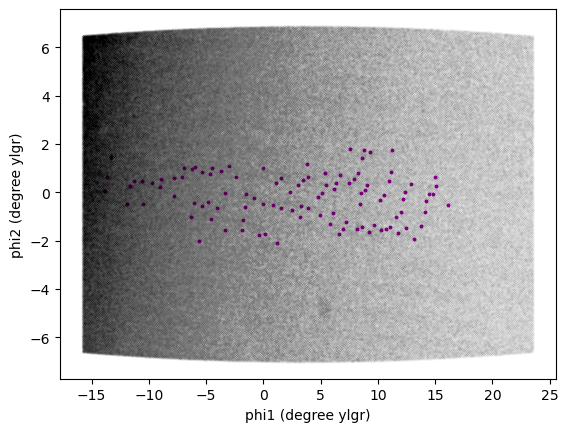

In [47]:
x = transformed.phi1
y = transformed.phi2
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.05)

x_star = ylgr_ylgr.phi1.value
y_star = ylgr_ylgr.phi2.value

plt.scatter(x_star, y_star, c = 'm', s = 3, alpha = 1)

plt.xlabel('phi1 (degree ylgr)')
plt.ylabel('phi2 (degree ylgr)')

I believe this should be a rectangle...

In [48]:
rectangle_results['phi1'] = transformed.phi1
rectangle_results['phi2'] = transformed.phi2
rectangle_results.info()

<Table length=2341125>
          name           dtype    unit                              description                                class     n_bad
----------------------- ------- -------- ------------------------------------------------------------------ ------------ -----
              source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn     0
                      l float64      deg                                                 Galactic longitude       Column     0
                      b float64      deg                                                  Galactic latitude       Column     0
                   pmra float64 mas / yr                         Proper motion in right ascension direction       Column     0
                  pmdec float64 mas / yr                             Proper motion in declination direction       Column     0
               parallax float64      mas                                                

In [49]:
rectangle_results['pm_phi1'] = transformed.pm_phi1_cosphi2
rectangle_results['pm_phi2'] = transformed.pm_phi2
rectangle_results.info()

<Table length=2341125>
          name           dtype    unit                              description                                class     n_bad
----------------------- ------- -------- ------------------------------------------------------------------ ------------ -----
              source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn     0
                      l float64      deg                                                 Galactic longitude       Column     0
                      b float64      deg                                                  Galactic latitude       Column     0
                   pmra float64 mas / yr                         Proper motion in right ascension direction       Column     0
                  pmdec float64 mas / yr                             Proper motion in declination direction       Column     0
               parallax float64      mas                                                

In [50]:
import pandas as pd

results_df = rectangle_results.to_pandas()

In [51]:
results_df.shape

(2341125, 22)

In [52]:
results_df.head()

,source_id,l,b,pmra,pmdec,parallax,ra,dec,bp_rp,phot_bp_mean_mag,...,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_error,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux,phi1,phi2,pm_phi1,pm_phi2
0,3471538300609820672,296.221669,32.659637,8.020114,-3.158776,2.188459,186.345449,-29.872391,NaN,NaN,...,NaN,NaN,0.939381,NaN,NaN,94.317576,-8.790292,-6.714127,-6.310832,-8.864695
1,3790783455945012864,262.249230,53.330713,-0.503562,-3.717324,0.195498,169.932077,-2.138080,0.772600,20.285221,...,8.918765,7.623309,0.929325,105.033676,124.196604,174.374452,23.130198,-4.817184,-0.632910,-1.482014
2,3790407835284866688,263.743415,53.165651,-21.233739,-4.674600,-1.462654,170.571724,-2.784718,2.120682,21.440489,...,7.647307,9.233164,0.939085,36.242752,148.332147,126.965942,22.283387,-5.156094,6.482155,17.980910
3,3790407942659746304,263.763876,53.181849,-7.006989,-15.804448,0.336416,170.591001,-2.778233,0.753040,18.641747,...,8.404710,6.529871,1.651979,477.219236,554.211411,872.119659,22.281887,-5.176356,-9.295011,9.185175
4,3790407942659748480,263.749128,53.170708,-1.406945,-3.094775,1.294799,170.577408,-2.782467,0.840406,20.345387,...,8.182745,8.470958,0.995779,99.371536,125.073826,159.426524,22.283258,-5.162200,0.246697,-0.906338


In [53]:
results_df

,source_id,l,b,pmra,pmdec,parallax,ra,dec,bp_rp,phot_bp_mean_mag,...,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_error,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_flux,phi1,phi2,pm_phi1,pm_phi2
0,3471538300609820672,296.221669,32.659637,8.020114,-3.158776,2.188459,186.345449,-29.872391,NaN,NaN,...,NaN,NaN,0.939381,NaN,NaN,94.317576,-8.790292,-6.714127,-6.310832,-8.864695
1,3790783455945012864,262.249230,53.330713,-0.503562,-3.717324,0.195498,169.932077,-2.138080,0.772600,20.285221,...,8.918765,7.623309,0.929325,105.033676,124.196604,174.374452,23.130198,-4.817184,-0.632910,-1.482014
2,3790407835284866688,263.743415,53.165651,-21.233739,-4.674600,-1.462654,170.571724,-2.784718,2.120682,21.440489,...,7.647307,9.233164,0.939085,36.242752,148.332147,126.965942,22.283387,-5.156094,6.482155,17.980910
3,3790407942659746304,263.763876,53.181849,-7.006989,-15.804448,0.336416,170.591001,-2.778233,0.753040,18.641747,...,8.404710,6.529871,1.651979,477.219236,554.211411,872.119659,22.281887,-5.176356,-9.295011,9.185175
4,3790407942659748480,263.749128,53.170708,-1.406945,-3.094775,1.294799,170.577408,-2.782467,0.840406,20.345387,...,8.182745,8.470958,0.995779,99.371536,125.073826,159.426524,22.283258,-5.162200,0.246697,-0.906338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341120,6151649222468998272,296.077557,24.874698,-9.833853,3.783004,-0.928058,185.007125,-37.578661,1.241146,20.738907,...,5.120757,5.127749,0.620009,69.159885,125.908176,156.185854,-14.874290,-1.832068,8.302668,3.311657
2341121,6151649222471132288,296.088275,24.872855,-7.774807,0.050869,-1.377744,185.018973,-37.581790,1.165743,20.516014,...,6.054032,6.565362,0.555719,84.920283,144.228065,163.593619,-14.881746,-1.838581,4.042069,3.424603
2341122,6151649222471132416,296.087416,24.873622,-6.772011,-0.199839,0.520579,185.018127,-37.580925,1.386185,19.237852,...,7.213656,5.455266,0.843660,275.598183,573.444375,684.353782,-14.880661,-1.838441,3.318082,2.686900
2341123,6151649256828740736,296.087353,24.879614,-5.811253,-0.716163,-0.203735,185.019068,-37.574979,0.908587,19.135532,...,6.516250,6.588180,0.799386,302.833310,405.863566,592.286272,-14.875909,-1.842095,2.386713,2.119631


In [54]:
filename = 'ylgr_data.hdf'

results_df.to_hdf(filename, 'results_df', mode='w') 
# mode = w means that if the file is already written, it will be. overwritten
